# 7 clusters
# min=100 cases per cluster
# min start similarity 85%
# SequenceMatcher 6:48 minutes


In [1]:
import pandas as pd
import time
import numpy as np
import pickle
#from ClusteringPredictiveModel import ClusteringPredictiveModel
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from  matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from LastStateEncoder import LastStateEncoder
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import difflib as diff

C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
data=pd.read_csv('BPIC 2017 just complete cases.csv',sep=';')

In [3]:
#global case_id_col,event_col,timestamp_col,label_col,pos_label,numeric_cols,meta_event_data,other_col,variant_col

case_id_col = "Case ID"
event_col = "Activity"
timestamp_col = "Complete Timestamp"
label_col = 'lbl'
pos_label = 'A_Pending'
cat_cols = ['Resource','(case) LoanGoal','(case) ApplicationType'] 
numeric_cols = [ '(case) RequestedAmount',label_col]  
meta_event_data=["Complete Timestamp",'Start Timestamp','EventOrigin','OfferID','Unnamed: 0','Transition','milli_seconds',
          'EventID','lifecycle:transition','days','D_seconds',
          'Accepted', 'Selected' ,
          'FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms','outcome',
          'Variant', 'Action', 'CreditScore','OfferedAmount'
          ]
other_col= '(case) RequestedAmount'
variant_col='Variant index'

In [4]:
data.drop(meta_event_data,axis=1,inplace=True)
#data.drop(variant_col,axis=1,inplace=True)

In [5]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
data['Activity'] = lb_make.fit_transform(data['Activity'])

data.head() #Results in appending a new column to df

Case ID  Activity Resource  Variant index  \
0  Application_652823628         4   User_1              2   
1  Application_652823628         8   User_1              2   
2  Application_652823628         3   User_1              2   
3  Application_652823628        21  User_17              2   
4  Application_652823628         0  User_52              2   

  (case) ApplicationType         (case) LoanGoal  (case) RequestedAmount  \
0             New credit  Existing loan takeover                 20000.0   
1             New credit  Existing loan takeover                 20000.0   
2             New credit  Existing loan takeover                 20000.0   
3             New credit  Existing loan takeover                 20000.0   
4             New credit  Existing loan takeover                 20000.0   

         lbl  
0  A_Pending  
1  A_Pending  
2  A_Pending  
3  A_Pending  
4  A_Pending

In [6]:
lb_make.classes_

array(['A_Accepted', 'A_Cancelled', 'A_Complete', 'A_Concept',
       'A_Create Application', 'A_Denied', 'A_Incomplete', 'A_Pending',
       'A_Submitted', 'A_Validating', 'O_Accepted', 'O_Cancelled',
       'O_Create Offer', 'O_Created', 'O_Refused', 'O_Returned',
       'O_Sent (mail and online)', 'O_Sent (online only)',
       'W_Assess potential fraud', 'W_Call after offers',
       'W_Call incomplete files', 'W_Complete application',
       'W_Handle leads', 'W_Personal Loan collection',
       'W_Shortened completion', 'W_Validate application'], dtype=object)

# ===================

In [7]:
# divide into train and test data
np.random.seed(22)
sample_cases_KMedoide = np.random.choice(data[case_id_col].unique(), len(data[case_id_col].unique()))
train_cases_KMedoide, test_cases_KMedoide = train_test_split(sample_cases_KMedoide , train_size = 4.0/5, random_state = 22 )
train_KMedoide = data[data[case_id_col].isin(train_cases_KMedoide)]
test_KMedoide = data[data[case_id_col].isin(test_cases_KMedoide)]

C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
grouping=train_KMedoide.groupby(['Case ID']).apply(lambda x:(x.head(1)))
unique_variants=list(grouping.groupby(['Variant index']).head(1)['Case ID'])
uniques=train_KMedoide[train_KMedoide['Case ID'].isin (unique_variants)]

In [9]:
protein=['I', 'T', 'F', 'V', 'D', 'Y',
         'B', 'Z', 'Q', 'L','P','E', 'G', 'H',
         'M', 'A', '-','*', '.', 'W', 'N', 'K', 'S', 'X', 'C', 'R']
def trace(x):
    l=''
    for ac in x['Activity']:
        l+=chr(int(ac)+ascii_offset)
    return l


ascii_offset=161

# aggregate activities by case
grouped = uniques.groupby(['Case ID'], sort=False)

# extract  encoded trace from actvities
Activities_train = grouped.apply(lambda x: trace(x) )

In [10]:
label = uniques.groupby(['Case ID'],sort=False).first()['lbl']

In [11]:
ac_lbl=pd.DataFrame(columns=['Case ID','Activity','lbl','Variant'])
ac_lbl['Case ID']=Activities_train.index
ac_lbl['Activity']=list(Activities_train)
ac_lbl['lbl']=list(label)
ac_lbl['Variant']=list(uniques['Variant index'].unique())
ac_lbl.head()

Case ID                      Activity          lbl  Variant
0  Application_1018615109         ¥©¤¶¡­®­®±±´£ºª°µ§«¨¬    A_Pending       49
1   Application_196483749       ¥¶¤¡­®²´£¬­®±­®±­®±¢¬¬¬  A_Cancelled     1124
2  Application_1699757505   ¥©¤¶¡­®²´£­®±­®±¬ºª°µ§ºª«¨¬    A_Pending     1126
3  Application_1825104006  ¥©¤¶¡­®­®±±´£­®­®±±­®±¢¬¬¬¬¬  A_Cancelled      798
4  Application_1405679737        ¥©¤¶¡­®±´£ºª°µ§ºªºµ§¢¬  A_Cancelled     1128

# ==================Recommendation system techniques========

# functions:

In [12]:
def getGramsNumber(string, q):
    return (len(string) + (q - 1) * 2 + 1) - q

In [13]:
def getUnNormalisedSimilarity(s1, s2, q):
    difference = 0
    array3temp=[]
    array3temp.extend(s1)
    array3temp.extend(s2)
    #array3=array3temp
    array3 = np.unique(array3temp)
    
    for i  in range(len(array3)):
        token = array3[i]
        matchingQGrams1 = s1.count(token)
        matchingQGrams2 = s2.count(token)
        if matchingQGrams1 > matchingQGrams2 :
            difference += matchingQGrams1 - matchingQGrams2
        else:
            difference += matchingQGrams2 - matchingQGrams1
    return difference

In [14]:
# function of q_grams_similarity

def q_grams_similarity(string1, string2, q):
    array1_steps = getGramsNumber(string1, q)
    array2_steps = getGramsNumber(string2, q)
    maxQGramsMatching = array1_steps + array2_steps
    if (maxQGramsMatching == 0):
        return 0.00;
    else :
        return (maxQGramsMatching - getUnNormalisedSimilarity(string1, string2, q)) / maxQGramsMatching
            
    

In [15]:
#This function returns the symmetric matrix associated to a triangular matrix
#It returns a matrix
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

$$Cluster_{k}AverageIntraSimilarity=CAIS_{k}=\dfrac{\sum_{i=0}^{m_k}S(i,CC_k)}{m_k}$$
<center>Where $m_{k}$ is the number of users assigned to the cluster, $CC_{k}$ is the cluster medoid</center>

In [16]:
#This function computes the average intra-similarity of a cluster
#It returns a float

# clusterMedoidID = int : ID of the medoid of the cluster
# clusterList = list : List of clusters associations for each user (clusterList[i]=6 means that ith user is in the cluster associated to medoid 6 which is user n°6)
# similarities = array : Similarity matrix

def calculateClusterAvgSimilarity(clusterMedoidID,clusterList,similarities):
    clusters, counts=np.unique(clusterList, return_counts=True)
    clusterMembers=[]
    for count, i in enumerate(clusterList): #Generate list of users in the cluster (medoid included)
        if (i==clusterMedoidID):
                clusterMembers.append(count)     
   
    tempSumOfSim=0
    for i in clusterMembers: #Sum the similarities between members and cluster medoid
            tempSumOfSim+=similarities[i,int(clusterMedoidID)]
    avgClusterSimilarity=tempSumOfSim/(len(clusterMembers)) #Divide the sum by the number of users in cluster in order to get the average
        
    return avgClusterSimilarity

$$Cluster_{k}SimilaritySumWithCenter=\sum_{i=0}^{m_k}S(i,CC_k)$$
<center>Where $m_{k}$ is the number of users assigned to the cluster, $CC_{k}$ is the cluster medoid</center>

In [17]:
#This function is the same as calculateClusterAvgSimilarity() except it doesn't average the final sum
#It returns a float

# clusterMedoidID = int : ID of the medoid of the cluster
# clusterList = list : List of clusters associations for each user (clusterList[i]=6 means that ith user is in the cluster associated to medoid 6 which is user n°6)
# similarities = array : Similarity matrix

def calculateClusterSimilaritySumWithCenter(clusterMedoidID,clusterList,similarities):
    clusters, counts=np.unique(clusterList, return_counts=True)
    clusterMembers=[]
    for count, i in enumerate(clusterList):
        if (i==clusterMedoidID):
            clusterMembers.append(count)
            
    tempSumOfSim=0
    for i in clusterMembers:
        tempSumOfSim+=similarities[i,int(clusterMedoidID)]
    
    return tempSumOfSim

$$r_l=\dfrac{\sum_{i=0}^{N}S(i,CC_0) }{\sum_{k}^{N_l}\sum_{i=0}^{m_k}S(i,CC_k)}$$

<center>Where $m_{k}$ is the number of users assigned to the cluster $k$, $N_{l}$ is the current number of clusters, $CC_{k}$ is the cluster $k$ medoid, $N$ is the number of users, $CC_{0}$ is the first medoid</center>

$r_{l}$ is the ratio between the sum of the current clusters average intra-similarities and the original cluster average intra-similarity $\rightarrow$ Indicate how we are increasing/decreasing the intra-similarity in our system in comparasion with the original state

In [18]:
#This function computes RL ratio defined above
#It returns a float

#N_l = number of cluster at iteration l
#N = total number of users
#m_k = number of users in cluster k
#S(i,j) = similarity between i and j
#CC_k = n° k cluster center/medoid 


# clusterMedoidID = int : ID of the medoid of the cluster
# gamma0 = float : Sum of similarities between objects cluster medoid at the origin
# similarities = array : Similarity matrix
def calculateSimilarityRatioRL(clusterList,similarities,gamma0):
    clusters, counts=np.unique(clusterList, return_counts=True)
    
    systemSimilaritySum=0
    for i in clusters :
        systemSimilaritySum+=calculateClusterSimilaritySumWithCenter(i,clusterList,similarities)
        
    similarityRatioRL=gamma0/systemSimilaritySum
    #similarityRatioRL=systemSimilaritySum/gamma0 #Old version of the criterion
    
    return similarityRatioRL

$$\gamma_l=\dfrac{\sum_{k}^{N_l}\sum_{i=0}^{m_k}S(i,CC_k)}{N_l}$$

Where $m_{k}$ is the number of users assigned to the cluster $k$, $N_{l}$ is the current number of clusters, $CC_{k}$ is the cluster $k$ medoid

In [19]:
#This function computes GammaL ratio defined in paper
#It returns a float

#N_l = number of cluster at iteration l
#m_k = number of users in cluster k
#S(i,j) = similarity between i and j
#CC_k = n° k cluster center/medoid 

# clusterList = list : List of clusters associations for each user (clusterList[i]=6 means that ith user is in the cluster associated to medoid 6 which is user n°6)
# similarities = array : Similarity matrix
def calculateGammaL(clusterList,similarities):
    clusters, counts=np.unique(clusterList, return_counts=True)
    
    systemSimilaritySum=0
    for i in clusters :
        systemSimilaritySum+=calculateClusterSimilaritySumWithCenter(i,clusterList,similarities)
    
    gammaL=systemSimilaritySum/len(clusters)
    return gammaL

### 4.1 Generate similarity matrix

In [20]:
numberOfUsers=Activities_train.shape[0]

In [21]:
Activities_train.shape

(2613,)

In [22]:
q=3

start = time.time()
similarities=np.zeros([numberOfUsers,numberOfUsers])
for i in range(numberOfUsers) :
    clear_output(wait=True)
    print("Calculating similarities for : ",i, end='\r')
    
    for j in range(numberOfUsers) :
        if j>i: #Only generate the lower triangular values
            break
        elif i==j:
            similarities[i][j]=1
        else :
            similarities[i][j]= (diff.SequenceMatcher(None, Activities_train[i],Activities_train[j]).ratio())
                                
end = time.time()
print("Elapsed time : ",end - start)

Elapsed time :  413.0082588195801612


In [23]:
#Symmetrize the matrix as we only computed the lower triangular values
similarities=symmetrize(similarities)

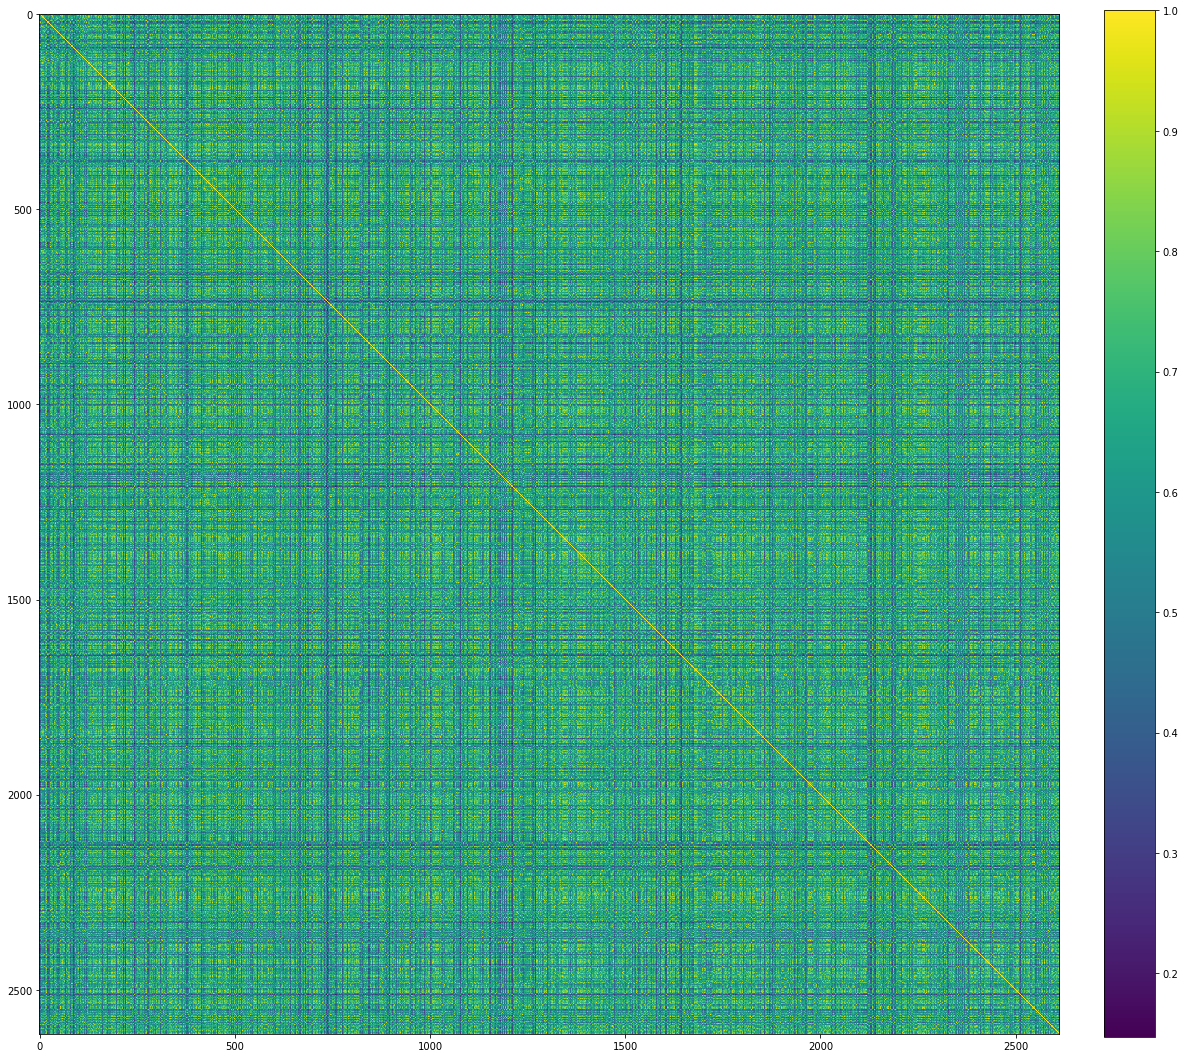

In [24]:
plt.figure(1, figsize=(20,20))
heatmap=plt.imshow(similarities, cmap='viridis', interpolation='nearest')
plt.colorbar(heatmap,fraction=0.046, pad=0.04)
plt.show()

#### Dump similarity matrix for further (quick) re-use

Dump the matrix

In [ ]:
with open('Clustering/SimilarityMatrix_diff.pkl', 'wb') as fp : # wb for "write bytes"
    pickle.dump(similarities, fp)

Load the matrix

In [18]:
with open ('Clustering/SimilarityMatrix_diff.pkl', 'rb') as fp:
     similarities = pickle.load(fp)

### 4.2 Initialize the clustering algorithm

In [81]:
nL=0 #number of cluster at iteration l
CCS=[] #List of Medoids
clusterList=np.zeros((numberOfUsers,)) #List of cluster assignation
sumOfSim=np.zeros((numberOfUsers,)) #Sum of similarities columns
rL_history=[] #History of RL ratio
ratioNL_history=[] #History of NL ratio
gammaL_history=[] #History of GammaL ratio
sumRLNL=[] #History of rL+NL

In [82]:
#Calculate sum of similarities for each column | Once calculated, it doesn't change and is, thus, re-usable
for i in range(numberOfUsers) :
    tempSum=np.sum(similarities[:,i])
    sumOfSim[i]=tempSum

In [83]:
#Get the most similar and least similar object to others (=> First two medoids)
maxOfSumSim=np.amax(sumOfSim)
indexMax=np.argmax(sumOfSim)
minOfSumSim=np.amin(sumOfSim)
indexMin=np.argmin(sumOfSim)

for i in range(numberOfUsers): #Firstly, we only assign all the items to the medoids with the highest sum of similarities with others (Genesis cluster)
    clusterList[i]=indexMax

nL+=1 #Add one to n° of cluster cause there's one global cluster (but add nothing to CCS as this first assignement is only to compute Gamma0) and assign everyone to genesis cluster (the one with the biggest SumOfSim)

gamma0=maxOfSumSim #For stop condition used later

#Compute system ratios for the genesis cluster
#tempRatioRL=calculateSimilarityRatioRL(clusterList=clusterList,gamma0=gamma0,similarities=similarities)
tempRatioRL=calculateSimilarityRatioRL(clusterList=clusterList,gamma0=gamma0,similarities=similarities)
rL_history.append(tempRatioRL)
tempRatioNL=nL/numberOfUsers
ratioNL_history.append(tempRatioNL)
tempGammaL=calculateGammaL(clusterList=clusterList,similarities=similarities)
gammaL_history.append(tempGammaL)
tempSumRLNL=tempRatioRL+tempRatioNL
sumRLNL.append(tempSumRLNL)

print("Genesis RL :",tempRatioRL,"| Genesis Ratio NL :",tempRatioNL,"| Genesis RL + Ratio NL :",tempSumRLNL,"| Genesis GammaL (=Gamma0) :",tempGammaL)
print("Max in",indexMax,":",maxOfSumSim,"| Min in",indexMin,":",minOfSumSim," | Gamma0 is :",gamma0)

#Add the two medoids to initizialize the bissecting process
CCS.append(indexMax)
CCS.append(indexMin)
nL+=1 #Only increase by one because we have delete the genesis cluster and add two new cluster => 1-1+2=2

Genesis RL : 0.9999999999999971 | Genesis Ratio NL : 0.0003827018752391887 | Genesis RL + Ratio NL : 1.0003827018752363 | Genesis GammaL (=Gamma0) : 1893.439686122042
Max in 1996 : 1893.4396861220366 | Min in 2298 : 857.9346276492377  | Gamma0 is : 1893.4396861220366


In [84]:
#Assign every object to the good cluster
for i in range(numberOfUsers):
    similarityWithMax=similarities[i,indexMax]
    similarityWithMin=similarities[i,indexMin]

    #if similarityWithMax>similarityWithMin:
    if   similarityWithMax>0.85 and   similarityWithMax>similarityWithMin : # for excluding even other high similarity item
        clusterList[i]=indexMax
    else:
        clusterList[i]=indexMin

In [85]:
#Compute system ratios 
tempRatioRL=calculateSimilarityRatioRL(clusterList=clusterList,gamma0=gamma0,similarities=similarities)
rL_history.append(tempRatioRL)
tempRatioNL=nL/numberOfUsers
ratioNL_history.append(tempRatioNL)
tempGammaL=calculateGammaL(clusterList=clusterList,similarities=similarities)
gammaL_history.append(tempGammaL)
tempSumRLNL=tempRatioRL+tempRatioNL
sumRLNL.append(tempSumRLNL)

print("First2 clusters RL :",tempRatioRL,"| First2 clusters Ratio NL :",tempRatioNL,"| First2 clusters RL + Ratio NL :",tempSumRLNL,"| First2 clusters GammaL (=Gamma0) :",tempGammaL)

First2 clusters RL : 1.873960321393811 | First2 clusters Ratio NL : 0.0007654037504783774 | First2 clusters RL + Ratio NL : 1.8747257251442893 | First2 clusters GammaL (=Gamma0) : 505.197379182964


In [86]:
print("Current clustering state :")
clusters, countsClusters=np.unique(clusterList, return_counts=True)
print("Clusters :",clusters)
print("Counts :",countsClusters)

Current clustering state :
Clusters : [1996. 2298.]
Counts : [ 264 2349]


### 4.3 Looping the algorithm until convergence

In [87]:
debug=False
#numberOfClusterStop=len(clusterList) #Cluster number simple condition
numberOfClusterStop=10

In [88]:
isOver=False
oldCCS=[]
oldClusterlist=[]
#previous_state_clusters_count=[]
#previous_state_clusters=[]

while(isOver==False):

    #'''
    cs=[list(clusterList).count(nn) for nn in list(np.unique(clusterList))]
    print(cs)
    if np.min(cs) not in [1,2,3]:
        print(np.min(cs))
        best_cluster_list=clusterList
    #''' 
   
    print('count: ',[list(clusterList).count(nn) for nn in list(np.unique(clusterList))])
        
    print('med: ',np.unique(clusterList))
    
    if(debug==False):
        #clear_output(wait=True)
        print("Current clustering state - nL :",nL)#, end='\r')
    #print([list(clusterList).count(nn) for nn in list(np.unique(clusterList))])

    
    
    clusters, countsClusters=np.unique(clusterList, return_counts=True)

    
    oldCCS=[]
    oldClusterlist=[]
    oldCCS.extend(CCS)
    oldClusterlist.extend(clusterList)
    
    #Calculate Avg similarity for each cluster
    clusterAvgSimiliraty={}
    for i in CCS :
        clusterAvgSimiliraty[i]=calculateClusterAvgSimilarity(clusterList=clusterList,clusterMedoidID=i,similarities=similarities)   
    
    #Detect the "weakest" cluster, delete it, and assign NaN to items that were in it
    weakestCluster=min(clusterAvgSimiliraty, key=clusterAvgSimiliraty.get)
    
    if(debug==True):
        print("Average similarities :",clusterAvgSimiliraty)
        print("Weakest medoid is :",weakestCluster)
        print("")
        
    CCS.remove(weakestCluster)
    
    #All the undefined cluster items are potential medoid candidates
    newMedoidsCandidates=[]
    
    #Set the cluster assignation to NaN and append the element to medoid candidates array
    for index,i in enumerate(clusterList) :
        if(i==weakestCluster):
            newMedoidsCandidates.append(index)# pic up all indexes of weak cluster
    
    if(debug==True):
        print("New medoid candidates are  :",newMedoidsCandidates)
    
    #Retrieve candidates sum of similarities
    candidatesSumOfSim=[]
    
    for i in newMedoidsCandidates:
        candidatesSumOfSim.append(sumOfSim[i])
    
    #Detect min and max of sum of similiraties (=> The two new medoids)
    maxSimSumCandidate=np.amax(candidatesSumOfSim)
    inArrayMaxSimSumCandidate=np.argmax(candidatesSumOfSim)
    indexMaxSimSumCandidate=newMedoidsCandidates[inArrayMaxSimSumCandidate]
    
    minSimSumCandidate=np.amin(candidatesSumOfSim)
    inArrayMinSimSumCandidate=np.argmin(candidatesSumOfSim)
    indexMinSimSumCandidate=newMedoidsCandidates[inArrayMinSimSumCandidate]
    
    if(debug==True):
        print("Strongest medoid candidate is :",indexMaxSimSumCandidate,"| Weakest medoid candidate is :",indexMinSimSumCandidate)
    
    #Add the two medoids to medoids array and increase nl (one delete, two added => +1)
    CCS.append(indexMaxSimSumCandidate)
    CCS.append(indexMinSimSumCandidate)
    nL+=1
    
    #Reassign all the items to the most similar medoid (Alternative version of bissecting algorithm with full reassignement, Steinbach and al. 2000)
    for count,i in enumerate(clusterList):
        pointSimilarityWithCenters={}
        for j in CCS:
            pointSimilarityWithCenters[j]=similarities[count,j]
        closestCluster=max(pointSimilarityWithCenters, key=pointSimilarityWithCenters.get)
        clusterList[count]=closestCluster  
        
    #Compute system ratios 
    #tempRatioRL=calculateSimilarityRatioRL(clusterList=clusterList,gamma0=gamma0,similarities=similarities)
    tempRatioRL=calculateSimilarityRatioRL(clusterList=clusterList,gamma0=gamma0,similarities=similarities)
    rL_history.append(tempRatioRL)
    tempRatioNL=nL/numberOfUsers
    ratioNL_history.append(tempRatioNL)
    tempGammaL=calculateGammaL(clusterList=clusterList,similarities=similarities)
    gammaL_history.append(tempGammaL)
    tempSumRLNL=tempRatioRL+tempRatioNL
    sumRLNL.append(tempSumRLNL)
    
    if(debug==True):
        print("")
        print("RL :",tempRatioRL,"| Ratio NL :",tempRatioNL,"| GammaL :",tempGammaL,"| RL+Ratio NL :",tempSumRLNL)

    #Check the stop conditions
    
    #Cluster number #unitiy existance# condition 
  

        
    if (nL==numberOfClusterStop)  :#or np.min(cs)==1:
        isOver=True

    

# Notice: med contains indexes of medoids from ac_lbl

[264, 2349]
264
count:  [264, 2349]
med:  [1996. 2298.]
Current clustering state - nL : 2
[1380, 35, 1198]
35
count:  [1380, 35, 1198]
med:  [1996. 2298. 2469.]
Current clustering state - nL : 3
[204, 1285, 5, 1119]
5
count:  [204, 1285, 5, 1119]
med:  [ 783. 1996. 2298. 2469.]
Current clustering state - nL : 4
[168, 1269, 1, 63, 1112]
count:  [168, 1269, 1, 63, 1112]
med:  [ 783. 1996. 2298. 2467. 2469.]
Current clustering state - nL : 5
[241, 130, 102, 1164, 1, 975]
count:  [241, 130, 102, 1164, 1, 975]
med:  [ 509.  783. 1656. 1996. 2298. 2469.]
Current clustering state - nL : 6
[238, 141, 63, 73, 1136, 2, 960]
count:  [238, 141, 63, 73, 1136, 2, 960]
med:  [ 509.  783. 1644. 1766. 1996. 2298. 2469.]
Current clustering state - nL : 7
[189, 95, 24, 66, 1093, 2, 931, 213]
count:  [189, 95, 24, 66, 1093, 2, 931, 213]
med:  [ 509.  783. 1587. 1766. 1996. 2298. 2469. 2583.]
Current clustering state - nL : 8
[130, 95, 157, 13, 64, 1071, 2, 880, 201]
count:  [130, 95, 157, 13, 64, 1071, 2,

In [89]:
array1=clusterList
med=[]
for m in np.unique(array1):
    med.append(int(m))
ln=len(med)
#for i in range(len(med)):
i=0
while i <len(med):
    var=ac_lbl['Variant'][array1==med[i]]
    if len(train_KMedoide[train_KMedoide['Variant index'].isin(var)]['Case ID'].unique())<=100:
        print(med)
        print(med[i],' to erase')
        s1=ac_lbl[ac_lbl['Variant'].isin(list(var.index))]['Activity'].values[0]
        sims=np.zeros(len(med))
        for j in range(len(sims)):
            if j==i:
                continue
            else:
                s2=ac_lbl['Activity'][int(med[j])]
                sims[j]=diff.SequenceMatcher(None, s1,s2).ratio()
        #print(sims)
        print(med[i],' erased')
        maxi=np.argmax(sims)
        print('new ',med[maxi])
        array1=np.where(array1==med[i], med[maxi], array1) 
        med=np.unique(array1)
        #continue
        i=0
    else:
        
        print('med[',i,'] pass')
        i+=1
med=[]
for m in np.unique(array1):
    med.append(int(m))
print(len(med))


med[ 0 ] pass
med[ 1 ] pass
med[ 2 ] pass
med[ 3 ] pass
[244, 509, 783, 1178, 1587, 1766, 1996, 2298, 2469, 2583]
1587  to erase
1587  erased
new  1178
med[ 0 ] pass
med[ 1 ] pass
med[ 2 ] pass
med[ 3 ] pass
[ 244.  509.  783. 1178. 1766. 1996. 2298. 2469. 2583.]
1766.0  to erase
1766.0  erased
new  2583.0
med[ 0 ] pass
med[ 1 ] pass
med[ 2 ] pass
med[ 3 ] pass
med[ 4 ] pass
[ 244.  509.  783. 1178. 1996. 2298. 2469. 2583.]
2298.0  to erase
2298.0  erased
new  1996.0
med[ 0 ] pass
med[ 1 ] pass
med[ 2 ] pass
med[ 3 ] pass
med[ 4 ] pass
med[ 5 ] pass
med[ 6 ] pass
7


In [106]:
clusters_array=[]
for i in med:
    var=ac_lbl['Variant'][array1==int(i)]
    cluster_i=train_KMedoide[train_KMedoide['Variant index'].isin(list(var))]
    name='sequence matcher clusters/cluster_'+str(i)+'.csv'
    cluster_i.to_csv(name,sep=';')
    clusters_array.append(cluster_i)

In [91]:
medoide_table=pd.DataFrame(columns=['variant','Case ID','Activity'])
medoide_table['variant']=ac_lbl['Variant'][med]
medoide_table['Case ID']=list(ac_lbl['Case ID'][med])
medoide_table['Activity']=list(ac_lbl['Activity'][med])
medoide_table.index=range(len(med))
medoide_table

variant                 Case ID                          Activity
0       88  Application_1168520628                         ¥©¤¶¡­®¢¬
1     1689  Application_1882088228           ¥©¤¶¡­®±´£­®±¬­®±ºª°¦¯¯
2     2000  Application_1653948637  ¥©·¤¶¡­®­®±±´£­®­®±±­®±ºª°¢¬¬¬¬¬
3     2439  Application_1177121671                     ¥©¤¡­®±´£ºª¦¯
4     3345   Application_886373645           ¥©¶¤¡­®±´£­®±ºª°µ§ºª«¨¬
5      306  Application_1017777344            ¥©¤¶¡­®­®±´£ºª°µ§ºª«¨¬
6      408   Application_129816772                 ¥©·¶¤¡­®±´£­®¬±¢¬

In [92]:
# for filling empty encoded columns
###################################
all_users=pd.Series(data['Resource'].values).unique()#   one time
all_goal=pd.Series(data['(case) LoanGoal'].values).unique()
all_types=pd.Series(data['(case) ApplicationType'].values).unique()
global d1

d=list(['Resource_'+str(u) for u in all_users  ])
d1=list(['(case) LoanGoal_'+str(u) for u in all_goal  ])
d2=list(['(case) ApplicationType_'+str(u) for u in all_types  ])

for i in d:
    d1.append(i)
for i in d2:
    d1.append(i)


In [93]:
len(d1)

161

In [94]:
#encoder
data_encoder = LastStateEncoder(case_id_col, timestamp_col, cat_cols, numeric_cols, fillna=True)

# encoding all features 
all_encode=data[data['Case ID'].isin(sample_cases_KMedoide)]
all_encode=data_encoder.transform(all_encode)
cls_features=all_encode.columns

#clussifier
clss = [RandomForestClassifier(n_estimators=100, random_state=22) for _ in med]

#train clussifiers
for i in range(len(med)) :
    cluster_encode=data_encoder.transform(clusters_array[i])
    missing_columns=[col for col in d1 if col not in list(cls_features)]
    mc=pd.DataFrame(columns=missing_columns)
    cluster_encode=pd.concat([cluster_encode,mc],ignore_index=True,sort=False).fillna(0)
    clss[i].fit(cluster_encode.drop([case_id_col, label_col], axis=1), cluster_encode[label_col]) 
    

In [95]:
len(d1)

161

In [96]:
clss[0].n_features_

162

# now lest test our model:

In [97]:
# fit finished
#then predict:

In [98]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
test_KMedoide['Activity'] = lb_make.fit_transform(test_KMedoide['Activity'])

test_KMedoide.head() #Results in appending a new column to df

C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Case ID  Activity Resource  Variant index  \
112  Application_1266995739         4   User_1             30   
113  Application_1266995739         8   User_1             30   
114  Application_1266995739         3   User_1             30   
115  Application_1266995739        21  User_19             30   
116  Application_1266995739         0   User_3             30   

    (case) ApplicationType         (case) LoanGoal  (case) RequestedAmount  \
112             New credit  Existing loan takeover                  7000.0   
113             New credit  Existing loan takeover                  7000.0   
114             New credit  Existing loan takeover                  7000.0   
115             New credit  Existing loan takeover                  7000.0   
116             New credit  Existing loan takeover                  7000.0   

             lbl  
112  A_Cancelled  
113  A_Cancelled  
114  A_Cancelled  
115  A_Cancelled  
116  A_Cancelled

In [99]:
def trace(x):
    l=''
    for ac in x['Activity']:
        l+=chr(int(ac)+ascii_offset)
    return l


ascii_offset=161

# aggregate activities by case
grouped = test_KMedoide.groupby(['Case ID'], sort=False)

# extract  encoded trace from actvities
Activities_test = grouped.apply(lambda x: trace(x) )

In [100]:
label = test_KMedoide.groupby(['Case ID'],sort=False).first()['lbl']

In [101]:
ac_lbl_test=pd.DataFrame(columns=['Case ID','Activity','lbl'])
ac_lbl_test['Case ID']=Activities_test.index
ac_lbl_test['Activity']=list(Activities_test)
ac_lbl_test['lbl']=list(label)
ac_lbl_test.head()

Case ID                 Activity          lbl
0  Application_1266995739        ¥©¤¶¡­®±´£¹ª°µ§¢¬  A_Cancelled
1  Application_1529124572      ¥©¤¶¡­®±´£¹ª°µ§¹ª«¨    A_Pending
2  Application_1120819670       ¥©¤¡­®±´£¹ª°µ§¹ª«¨    A_Pending
3  Application_1966208034             ¥©¤¶¡­®±´£¢¬  A_Cancelled
4  Application_1193723578  ¥©¤¶¡­®±´£­®±¹ª°µ§¹ª¦¯¯     A_Denied

In [102]:
# encoding name of cluster implicitely cluster name = np.argmax(sim)  it may neglagate a cluster if not max anytime!!


clustered_test=[]

for i in  range(ac_lbl_test.shape[0]) :
    sim=[]
    for j in range(len(medoide_table)):
        sim.append(diff.SequenceMatcher(None, ac_lbl_test['Activity'][i],medoide_table['Activity'][j]).ratio())
    clustered_test.append(np.argmax(sim))
clusters_names=np.unique(clustered_test)

print('distribution of test elements: ', [clustered_test.count(k) for k in clusters_names ])

distribution of test elements:  [987, 139, 54, 552, 1252, 2003, 719]


In [103]:
clusters_names

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [104]:
# predict outcomes for each cluster
cols = ['Case ID']+list(clss[0].classes_)
preds = pd.DataFrame(columns=cols)
actual = pd.DataFrame(columns=cols)
cluster_assignments=np.array(clustered_test )
#test_KMedoide1.index=test_KMedoide['Case ID']

for cl in clusters_names:

    cases = ac_lbl_test[cluster_assignments == cl]['Case ID']
    tmp = test_KMedoide[test_KMedoide[case_id_col].isin(cases)]
    test_encode = data_encoder.transform(tmp)
    
    missing_columns=[col for col in d1 if col not in cls_features]
    mc=pd.DataFrame(columns=missing_columns)
    test_encode=pd.concat([test_encode,mc],ignore_index=True, sort=False).fillna(0)
    test_encode.fillna(0, inplace=True)
    
    new_preds = pd.DataFrame(clss[cl].predict_proba(test_encode.drop([case_id_col, label_col], axis=1)))
    new_preds.columns = clss[cl].classes_
    new_preds[case_id_col] = list(test_encode['Case ID'])
    preds = pd.concat([preds, new_preds], axis=0, ignore_index=True,sort=False)
    
    actuals = pd.get_dummies(test_encode[label_col])
    actuals[case_id_col] = test_encode[case_id_col]
    actual = pd.concat([actual, actuals], axis=0, ignore_index=True,sort=False)
    
preds.fillna(0, inplace=True)
actual.fillna(0, inplace=True)

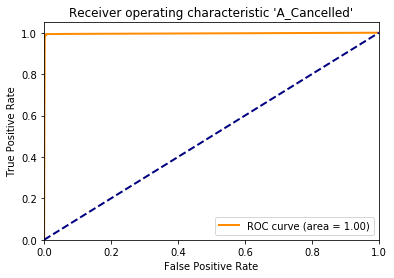

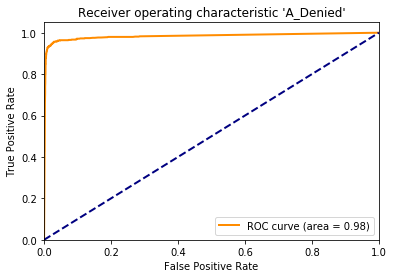

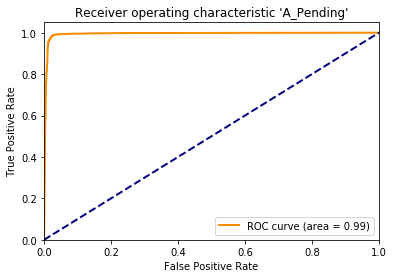

In [105]:
import sklearn.metrics as met
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
th=dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i],th[i] = met.roc_curve(actual[actual.columns.values[i+1]],preds[preds.columns.values[i+1]])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(3):
    plt.figure()
    lw = i
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic %r' %actual.columns.values[i+1])
    plt.legend(loc="lower right")
    plt.show()